<a href="https://colab.research.google.com/github/RafaelSotero-dev/Machine-Learning/blob/main/ConvolutionalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import display, HTML, IFrame
display(HTML("<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*uAeANQIOQPqWZnnuH-VEyw.jpeg'/>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
from torch.utils.data import DataLoader  
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

DATA_PATH = '/content/drive/MyDrive/Colab_Notebooks/DataSets-ML'

transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])

train_tensor = CIFAR10(DATA_PATH, train=True, download=False, transform=transforms)
test_tensor = CIFAR10(DATA_PATH, train=False, download=False, transform=transforms)

train_loader = DataLoader(train_tensor, batch_size=64, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=True)


In [ ]:
imgs = torch.stack([imgs for imgs, _ in train_tensor], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

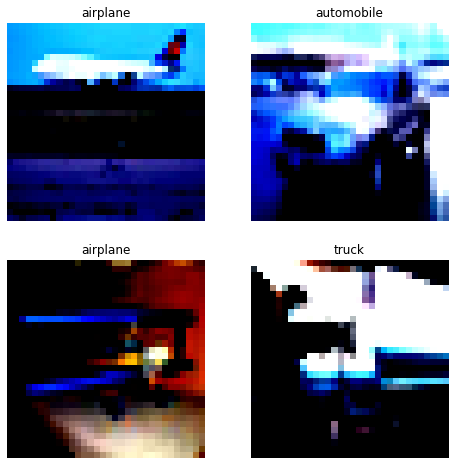

In [4]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

CATEGORIAS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_img(dataset, istensor=False):
    fig = plt.figure(figsize=(8,8))
    cols, rows = 2, 2
    for i in range(1, 5):
        sample_idx = torch.randint(len(dataset), size=(1,))
        imgs, labels = dataset[sample_idx]
        fig.add_subplot(rows, cols, i)
        plt.title(CATEGORIAS[labels])
        plt.axis('off')

        if istensor:
            plt.imshow(imgs.permute(1, 2, 0))
        else:
            plt.imshow(imgs)

plot_img(train_tensor, istensor=True)

In [5]:
class ConvolutionNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(1152, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        c = self.conv_layers(x)
        f = torch.flatten(c, 1)
        return self.linear_layers(f) 

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
cov_model = ConvolutionNetwork().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(cov_model.parameters(), lr=0.001)

In [8]:
def train_model(model, optimizer, lossfunc, train_dataloader):
    model.train()
    custo = 0.0
    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device) 

        pred = model(imgs)

        loss = lossfunc(pred, labels)
                        
        optimizer.zero_grad()

        loss.backward()

        custo += loss.item()
        optimizer.step()

    return custo / len(train_dataloader)

def test_model(model, lossfunc, dataloader):
    model.eval()
    custo = 0.0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device) 
            
            pred = model(imgs)

            loss = lossfunc(pred, labels)
                            
            custo += loss.item()
   
    return custo / len(dataloader)

In [9]:
epochs = 31
lista_custo_train = []
lista_custo_test = []
for e in range(epochs):
    result = train_model(cov_model, optimizer, criterion, train_loader)
    lista_custo_train.append(result)
    if e %10 == 0:
        print(f'LOSS Train: {result}')
        print('#'*30)

    test_loss = test_model(cov_model, criterion, test_loader)
    lista_custo_test.append(test_loss)

LOSS Train: 2.2948416538555603
##############################
LOSS Train: 1.7203655834393123
##############################
LOSS Train: 1.4480390676756953
##############################
LOSS Train: 1.317690019031315
##############################


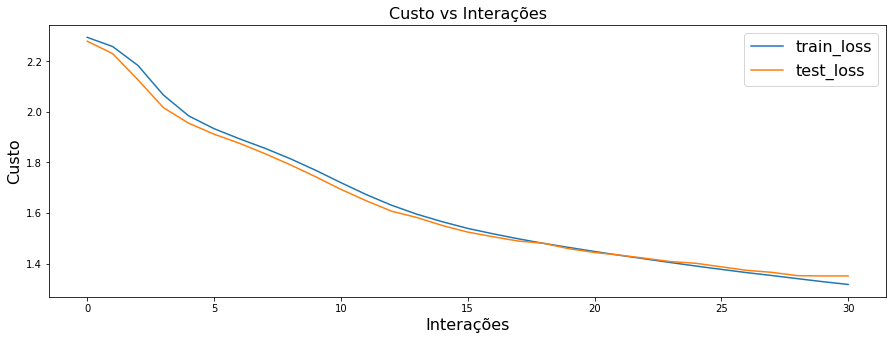

In [10]:
losses = { 'train_loss': lista_custo_train, 'test_loss': lista_custo_test }

def plot_losses(losses):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.gca()
    for name, value in losses.items():
        ax.plot(value, label=name)
    ax.legend(fontsize="16")
    ax.set_xlabel("Interações", fontsize="16")
    ax.set_ylabel("Custo", fontsize="16")
    ax.set_title("Custo vs Interações", fontsize="16")

plot_losses(losses)

In [12]:
print(lista_custo_train)

[2.2948416538555603, 2.2585988023396952, 2.183636888823546, 2.0670342398116657, 1.9842086414546918, 1.9336884572073016, 1.89372309028645, 1.8563881304562855, 1.8151239909784262, 1.7693784291786916, 1.7203655834393123, 1.6730803835117602, 1.6308740275290312, 1.5953390936717353, 1.5656382625974963, 1.5393707532711955, 1.517858442443106, 1.4980879179047197, 1.4799464505041957, 1.4638563614062337, 1.4480390676756953, 1.432913201544291, 1.4184830293935888, 1.4042367848288981, 1.3904802113237893, 1.3772144751323154, 1.3644704603783004, 1.35290864407254, 1.3406003779157654, 1.3286459517600897, 1.317690019031315]


In [11]:
cov_model.eval()
prob_dict = {}
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        pred = cov_model(imgs)
        new_pred = nn.functional.softmax(pred, dim=1) * 100
    for i, classname in enumerate(CATEGORIAS):
        prob = new_pred[0][i].item()
        prob_dict[classname] = [prob]

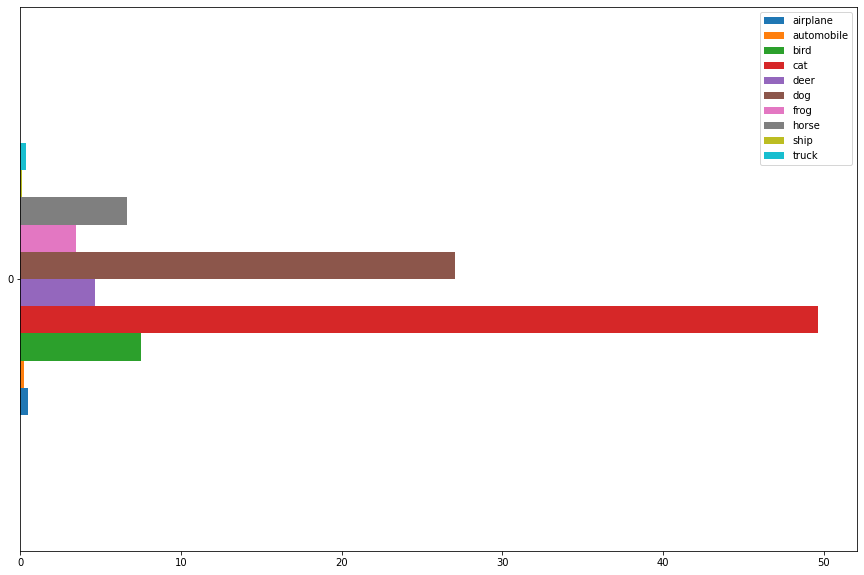

In [13]:
import pandas as pd

probDF = pd.DataFrame.from_dict(prob_dict)
probDF.plot(kind='barh', figsize=(15, 10))

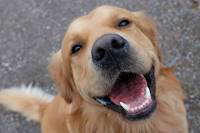

In [15]:
from PIL import Image

img = Image.open('/content/Dog.jpg')
img

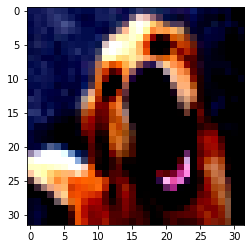

In [16]:
prep_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])

img_tensor = prep_transform(img)

plt.imshow(img_tensor.permute(1, 2, 0))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2bcb01520>,
      dtype=object)

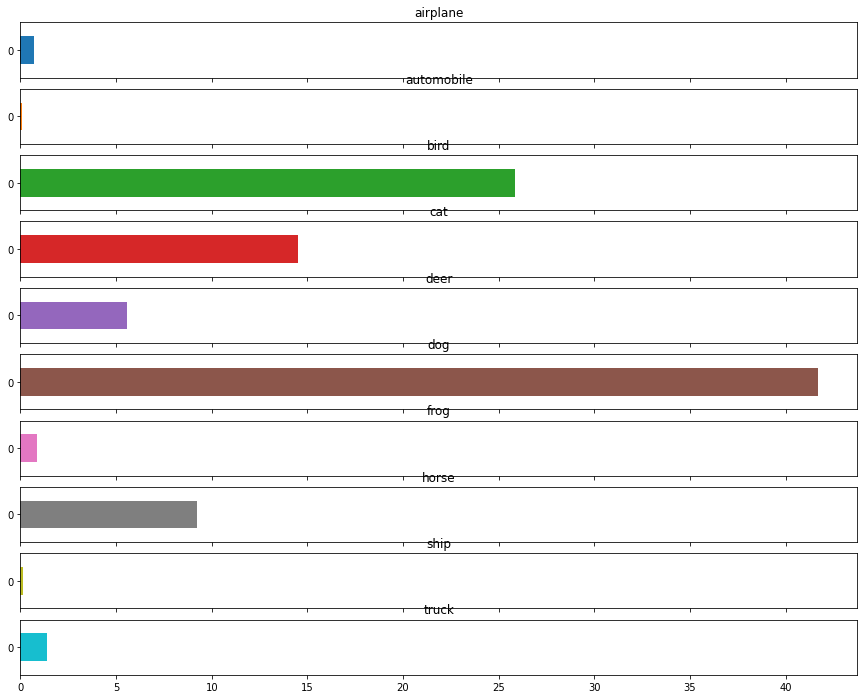

In [17]:
cov_model.eval()
prob_dict = {}
with torch.no_grad():
    pred = cov_model(img_tensor.unsqueeze_(0).to(device))
    probs = nn.functional.softmax(pred, dim=1) * 100
    for i, classname in enumerate(CATEGORIAS):
        prob = probs[0][i].item()
        prob_dict[classname] = [prob]
    
probDF = pd.DataFrame.from_dict(prob_dict)
probDF.plot(kind='barh', figsize=(15, 12), subplots=True, legend=False, )